# Evaluación emocional de una película

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

# Contents <a id='back'></a>

* [Etapa 1. Inicialización](#Initialization)
* [Etapa 2. Cargar datos](#Load_data)
* [Etapa 3. EDA](#EDA)
* [Etapa 4. Procedimiento de evaluación](#Evaluation_procedure) 
* [Etapa 5. Normalización](#normalization)
* [Etapa 6. División entrenamiento / prueba](#Training_test_division)
* [Etapa 7. Trabajar con modelos](#Working_with_models)
    * [7.1 Modelo 0 - Constante](#Model_0_Constant)
    * [7.2 Modelo 1 - NLTK, TF-IDF y LR](#Model_1_NLTK_TF_IDF_and_LR)
    * [7.3 Modelo 3 - spaCy, TF-IDF y LR](#Model_3_spaCy_TF_IDF_LR)
    * [7.4 Modelo 4 - spaCy, TF-IDF y LGBMClassifier](#Modelo_4_spaCy_TF_IDF_LGBMClassifier)
* [Etapa 8. Mis reseñas](#My_reviews)
    * [8.1 Modelo 2](#Model_2)
    * [8.2 Modelo 3](#Model_3)
    * [8.3 Modelo 4](#Model_4)
* [Etapa 9. Conclusiones](#end)

## Etapa 1. Inicialización <a id='Initialization'></a>

In [1]:
import math

import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
lemmatizer = WordNetLemmatizer()

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

from lightgbm import LGBMClassifier

In [2]:
#matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [4]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Etapa 2. Cargar datos <a id='Load_data'></a>

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
df_reviews = df_reviews.dropna()
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

No hay más valores faltantes. Ahora podemos verificar si existen filas duplicadas.

In [9]:
df_reviews.duplicated().sum()

0

No existen filas duplicadas. Ahora podemos examinar la distribución de clases en nuestro objetivo (la columna 'pos'). Podemos hacerlo trazando un histograma.

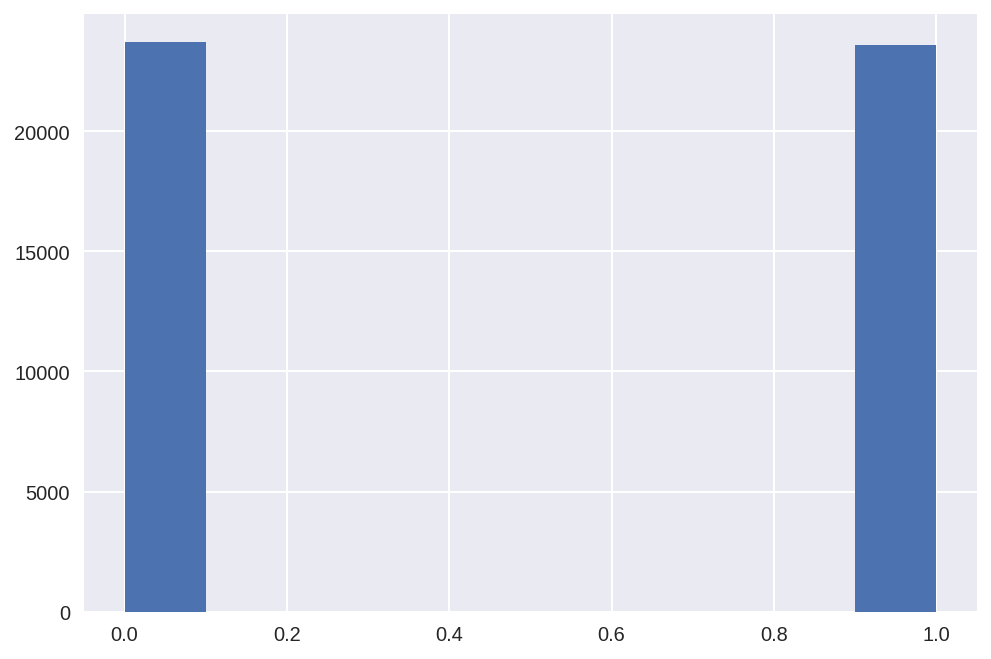

In [10]:
df_reviews['pos'].hist()
plt.show()

En el conjunto de datos completo, las clases (0 y 1) están balanceadas en términos de equilibrio.

## Etapa 3. EDA <a id='EDA'></a>

Veamos el número de películas y reseñas a lo largo de los años.

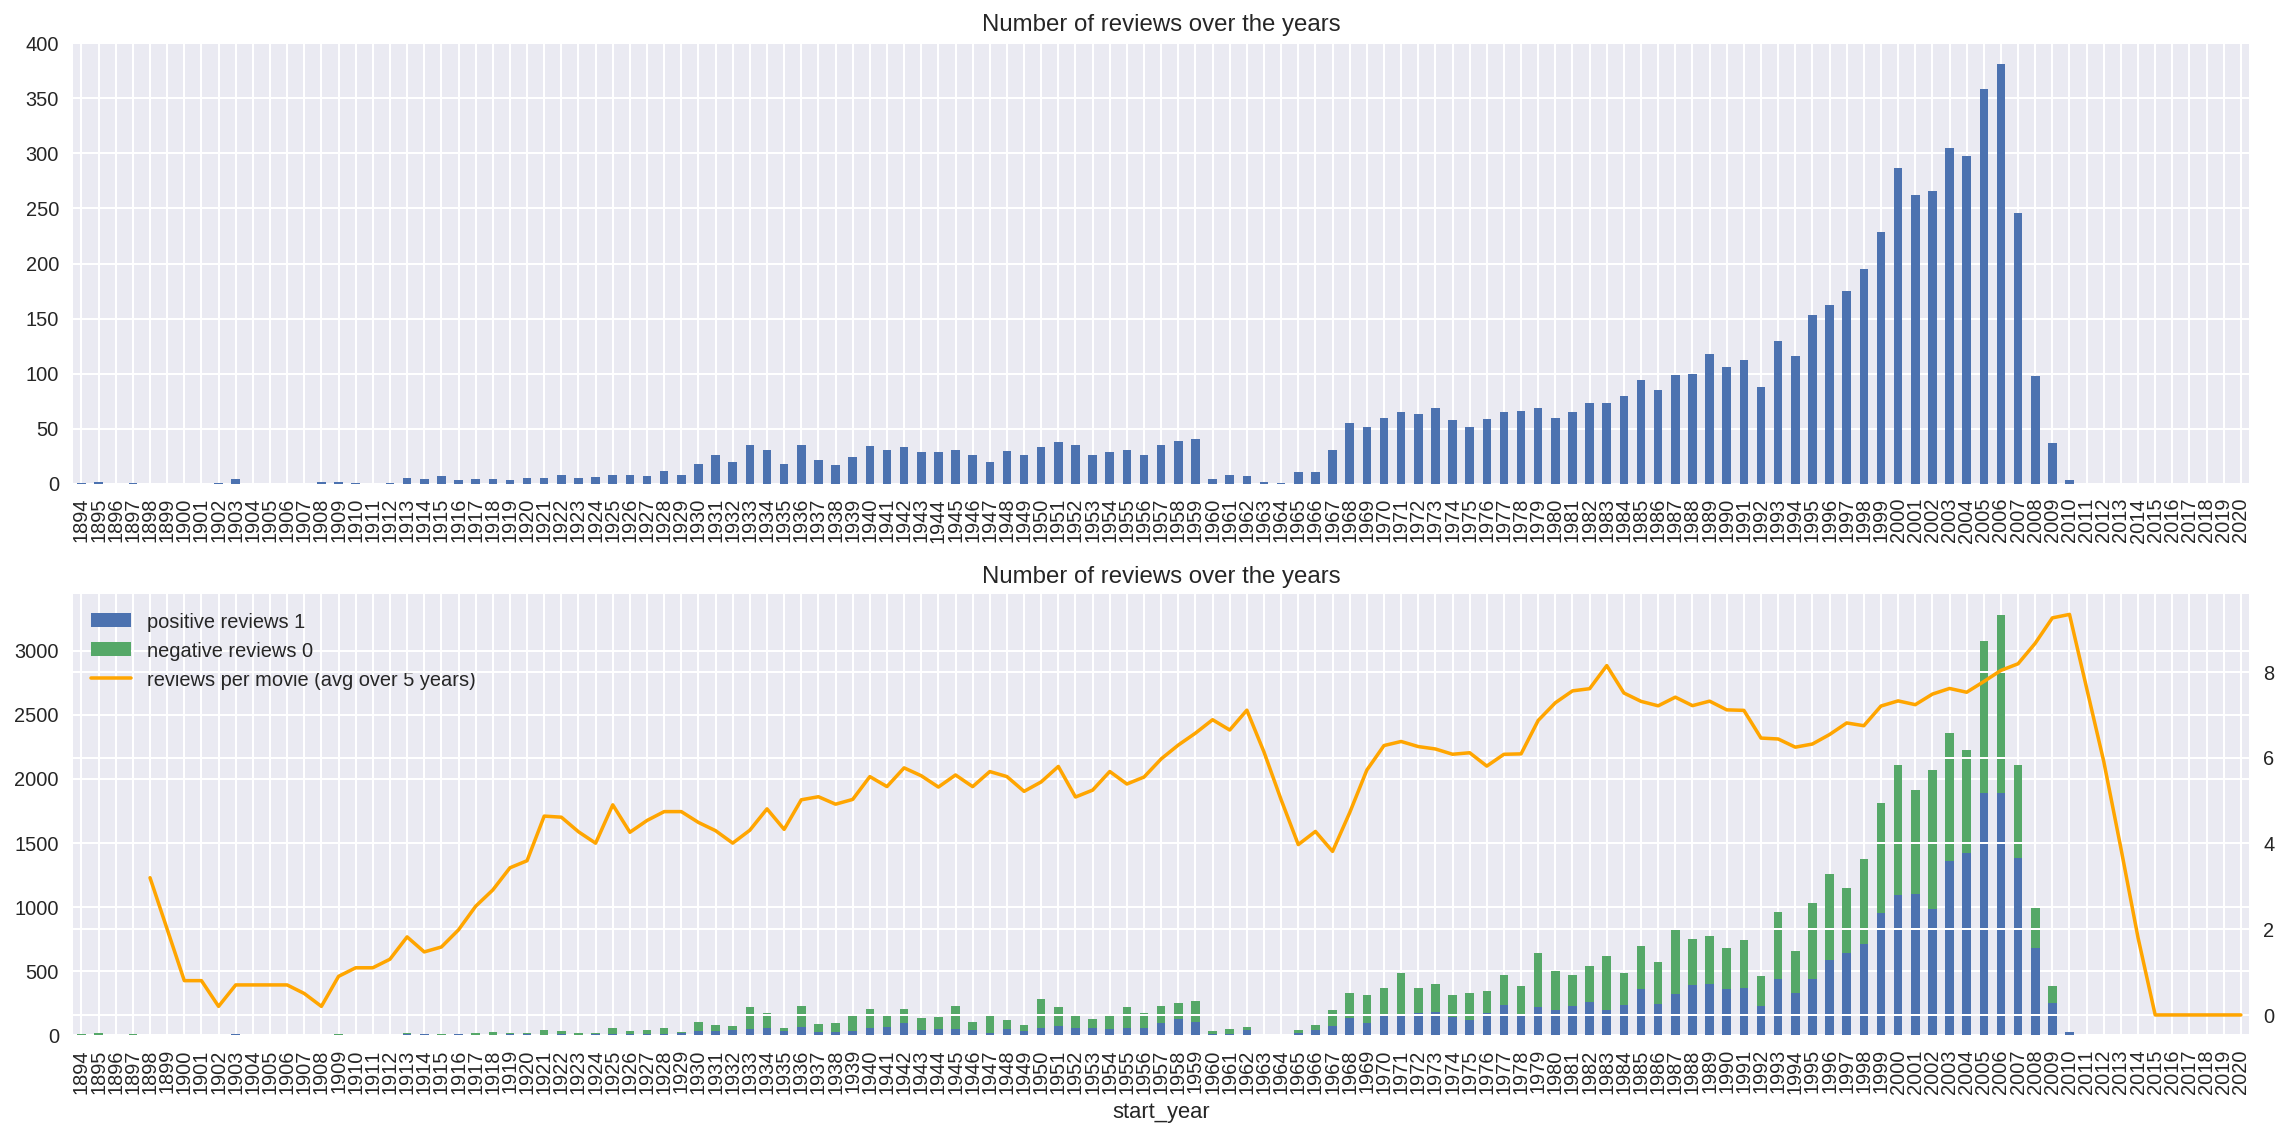

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Graph # 1
ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of reviews over the years')

# Graph # 2
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, ax=ax)
lines1, labels1 = ax.get_legend_handles_labels()
labels1=['positive reviews 1', 'negative reviews 0']

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)

axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines2, labels2 = axt.get_legend_handles_labels()

lines = lines1+lines2
labels = labels1+labels2

ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of reviews over the years')

fig.tight_layout()

Se puede notar un incremento general en la cantidad de películas, llegando a su punto más alto en 2006 y disminuyendo posteriormente. Lo mismo sucede con la cantidad de reseñas por película.

---

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

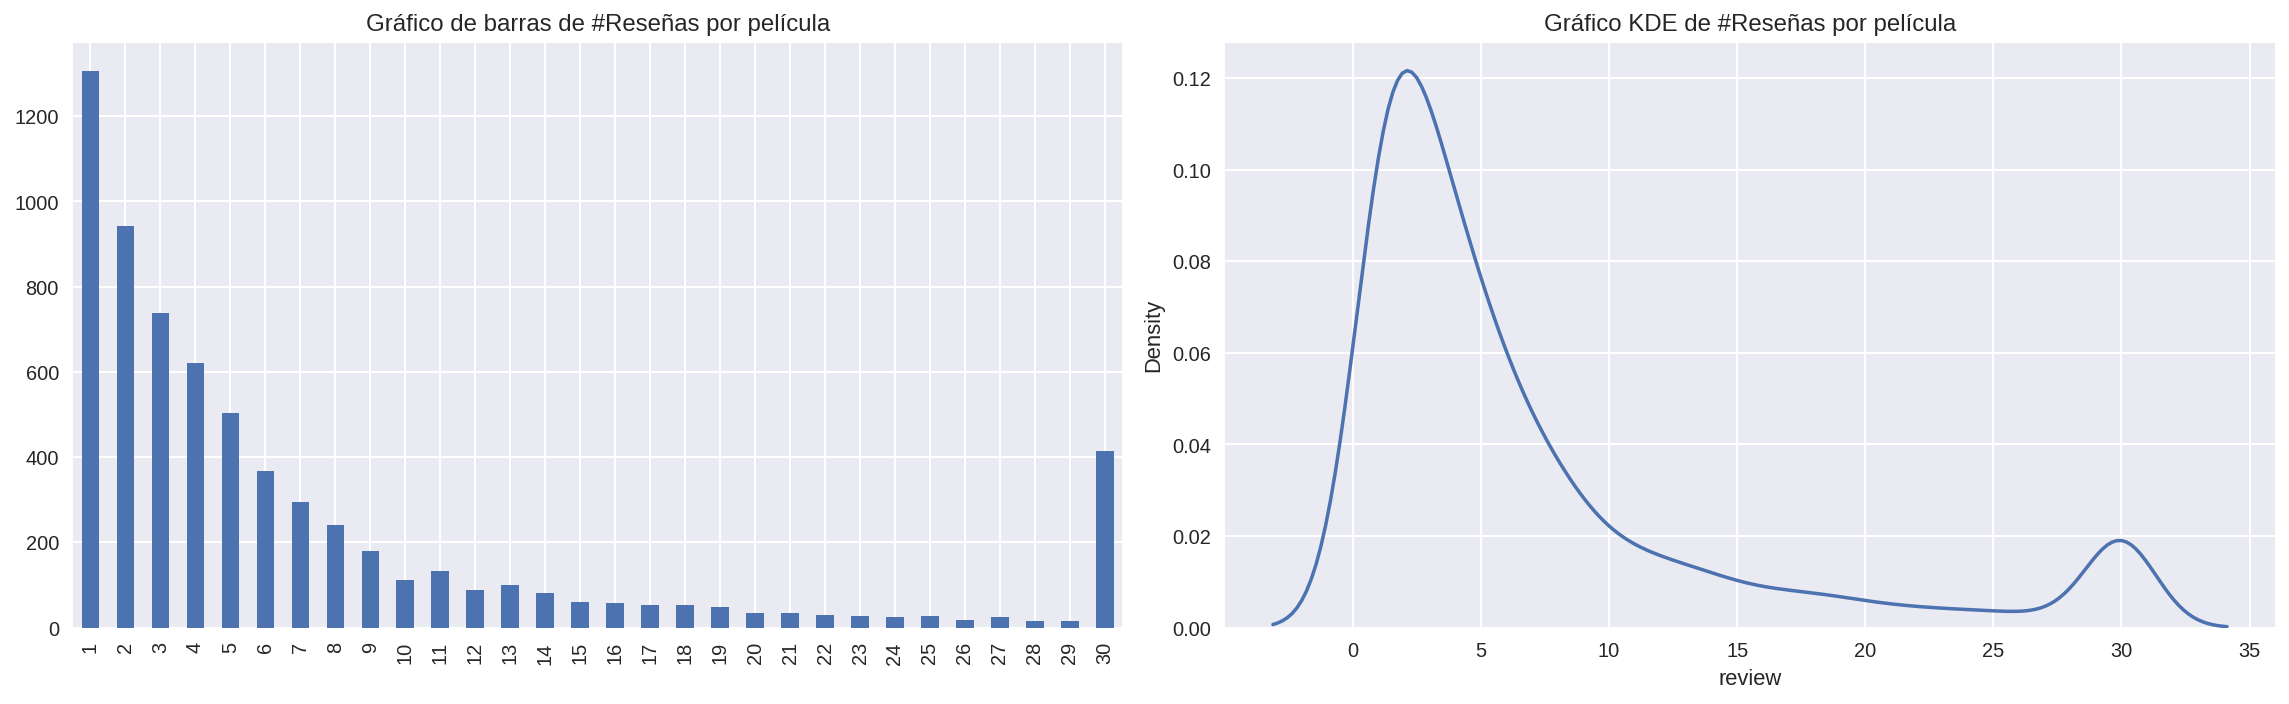

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Existe una mayor cantidad de películas que cuentan con una sola reseña, y podemos apreciar una disminución gradual a medida que aumenta el número de reseñas, seguida de un repentino aumento en las películas con 30 reseñas. Ahora, analicemos la distribución de las calificaciones tanto en los conjuntos de entrenamiento como en los de prueba.

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

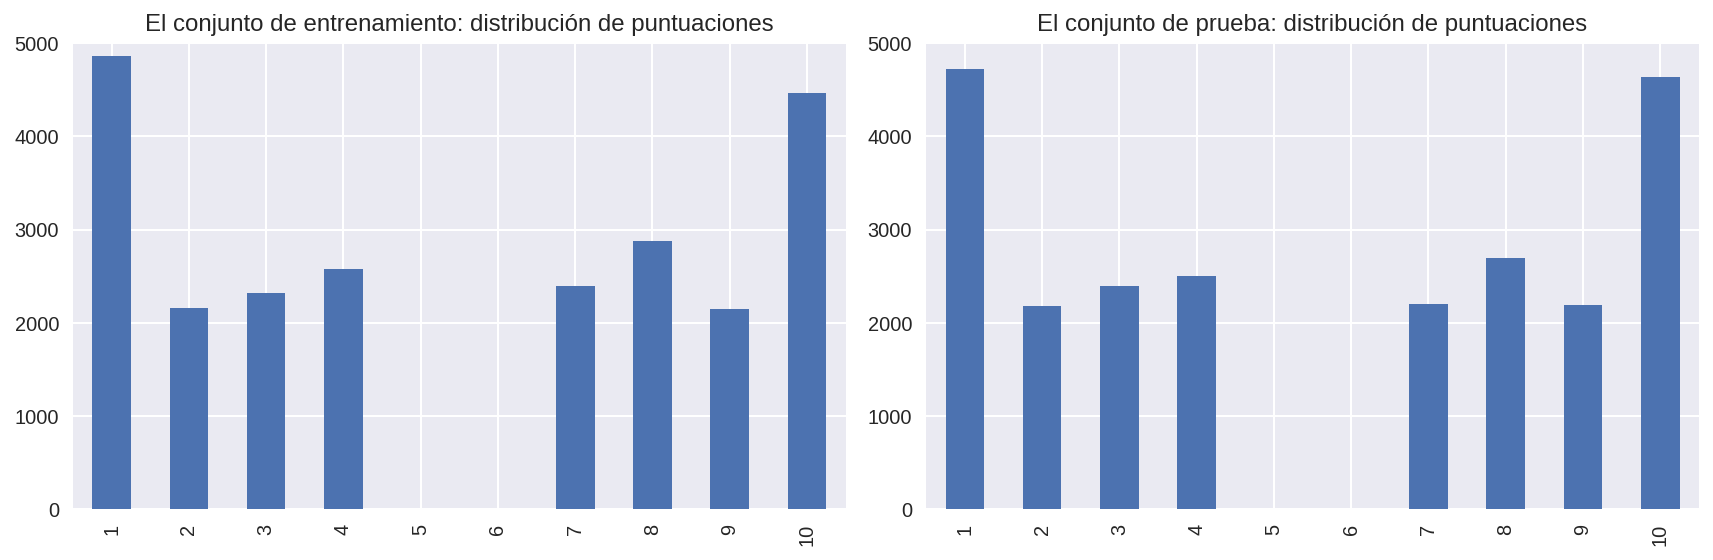

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Se puede observar que existen numerosas opiniones que otorgan una puntuación de 1, seguidas de cerca por aquellas que otorgan una puntuación de 10. La diferencia entre el número de opiniones que otorgan una puntuación de 2, 3 o 4, y aquellas que otorgan una puntuación de 7, 8 o 9, no es significativa. Asimismo, hay una escasez de valoraciones de 5 o 6.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

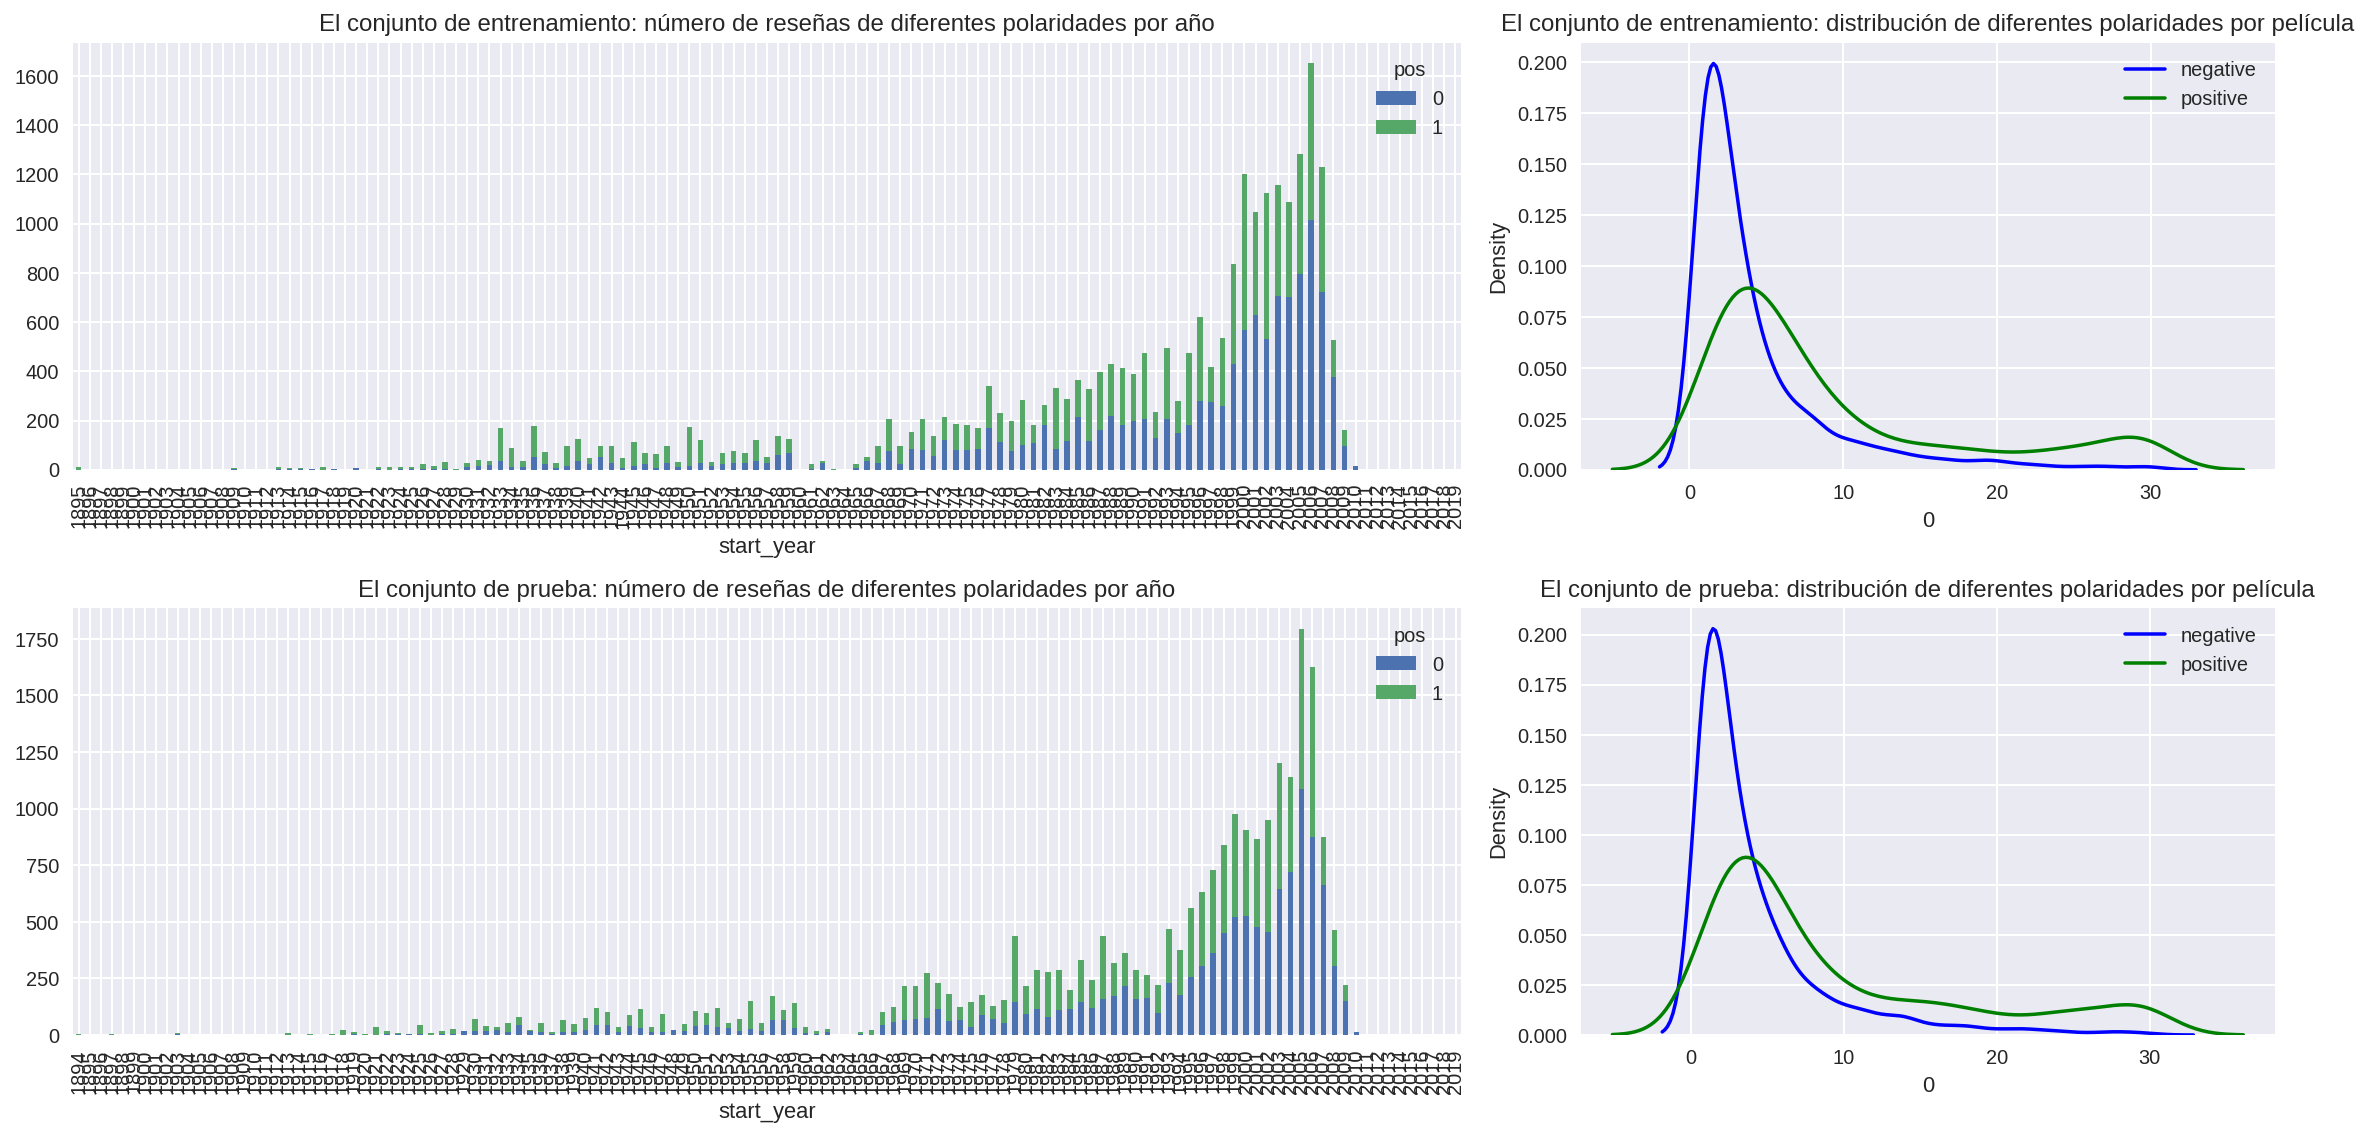

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

A lo largo de la mayoría de los años, ha habido una mayor cantidad de críticas negativas en comparación con las positivas.

## Etapa 4. Procedimiento de evaluación <a id='Evaluation_procedure'></a>

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Etapa 5. Normalización <a id='normalization'></a>

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [17]:
#normalización, es decir, minúsculas, texto sólo alfabético
df_reviews['review_norm']=df_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())
df_reviews['review_norm']=df_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))

In [18]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## Etapa 6. División entrenamiento / prueba <a id='Training_test_division'></a>

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Etapa 7. Trabajar con modelos <a id='Working_with_models'></a>

### Modelo 0 - Constante <a id='Model_0_Constant'></a>

In [20]:
#Obtención de características mediante lematización
f_train0=[]
f_test0=[]
for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop]
    lemmas = [lemmatizer.lemmatize(r) for r in result]
    l_join = " ".join(lemmas)
    f_train0.append(l_join)

for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop]
    lemmas = [lemmatizer.lemmatize(r) for r in result]
    l_join = " ".join(lemmas)
    f_test0.append(l_join)

#entrenamiento del modelo    
model=DummyClassifier().fit(f_train0, train_target)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


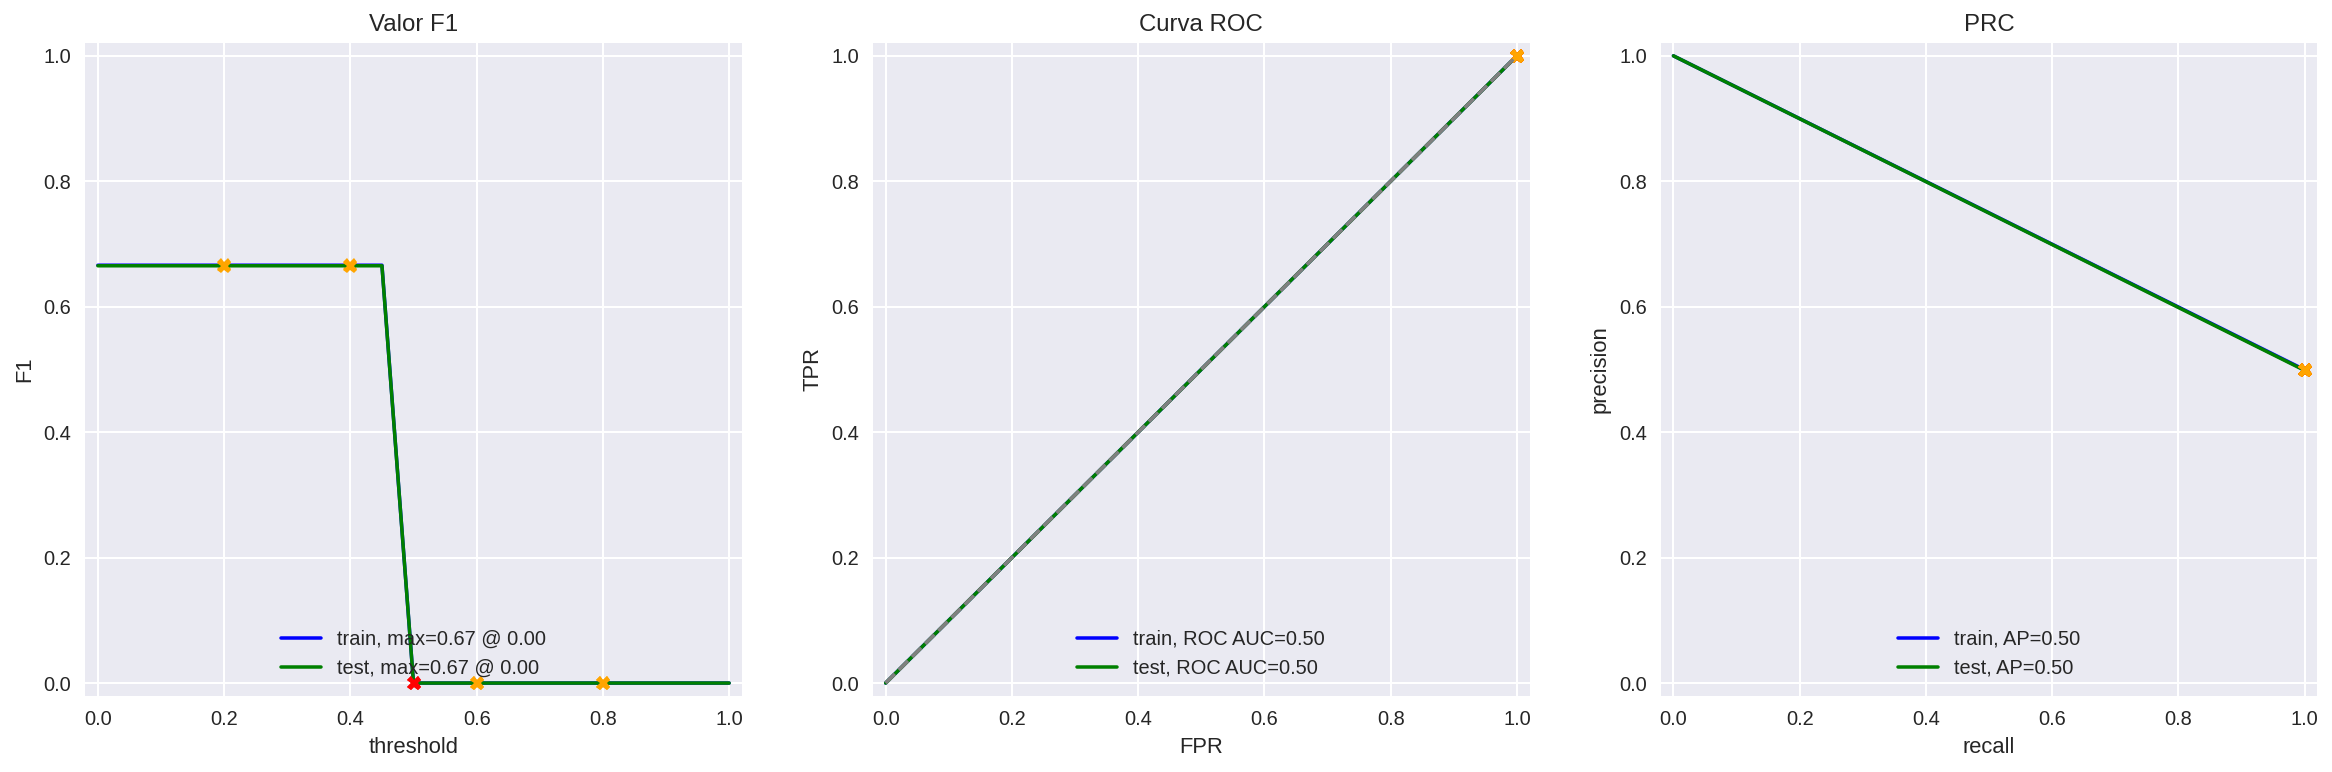

In [21]:
evaluate_model(model, f_train0, train_target, f_test0, test_target)

Nuestra puntuación F1 en el conjunto de pruebas es de 0,5, lo cual indica que hay margen de mejora para nuestros modelos futuros.

### Modelo 1 - NLTK, TF-IDF y LR <a id='Model_1_NLTK_TF_IDF_and_LR'></a>

TF-IDF

Consigamos nuestras caracteristicas

In [22]:
corp_train=[]
corp_test=[]

In [23]:
#entrenamiento
for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    corp_train.append(l_join)

In [24]:
#prueba
for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    corp_test.append(l_join)

In [25]:
#Vectorización de los corpus
count_tf_idf2=TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1,1))
train_features_1 = count_tf_idf2.fit_transform(corp_train)
test_features_1 = count_tf_idf2.transform(corp_test)

entrenamiento del modelo

In [26]:
model_1 = LogisticRegression(C=0.5).fit(train_features_1, train_target)

La evaluación del modelo se lleva a cabo utilizando la rutina de evaluación.

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


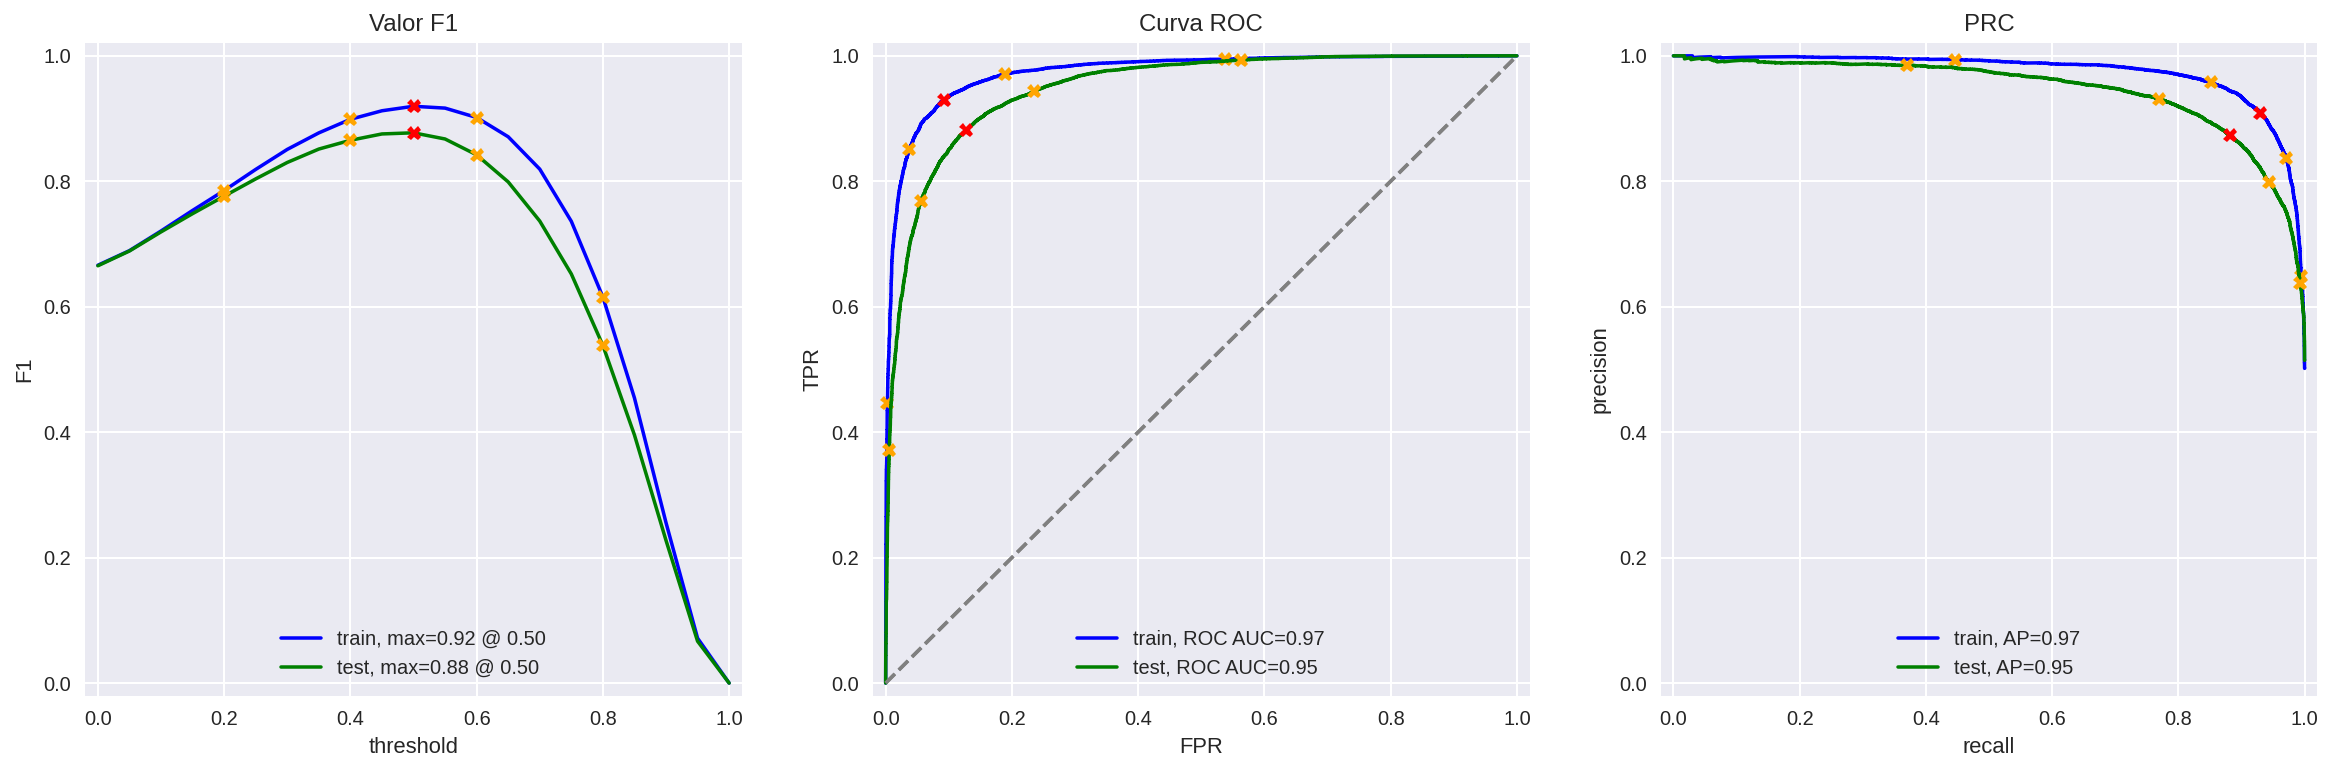

In [27]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

La puntuación F1 obtenida en el conjunto de pruebas es de 0,88, lo cual es considerablemente mejor que la del clasificador ficticio y supera nuestro requisito mínimo establecido.

### Modelo 3 - spaCy, TF-IDF y LR <a id='Model_3_spaCy_TF_IDF_LR'></a>

In [28]:
#Función que procesa, lematiza el texto
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [29]:
#Obtener las características
c_train3=[]
c_test3=[]

#entrenamiento
for text in df_reviews_train['review_norm']:
    result=text_preprocessing_3(text)
    c_train3.append(result)

#prueba
for text in df_reviews_test['review_norm']:
    result=text_preprocessing_3(text)
    c_test3.append(result)

#Vectorizando el corpus 
count_tf_idf3=TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1,1))
f_train3 = count_tf_idf3.fit_transform(c_train3)
f_test3 = count_tf_idf3.transform(c_test3)

entrenando el modelo

In [30]:
model_3=LogisticRegression(C=0.5).fit(f_train3, train_target)

modelo de evaluacion

          train  test
Accuracy   0.91  0.87
F1         0.91  0.87
APS        0.97  0.94
ROC AUC    0.97  0.94


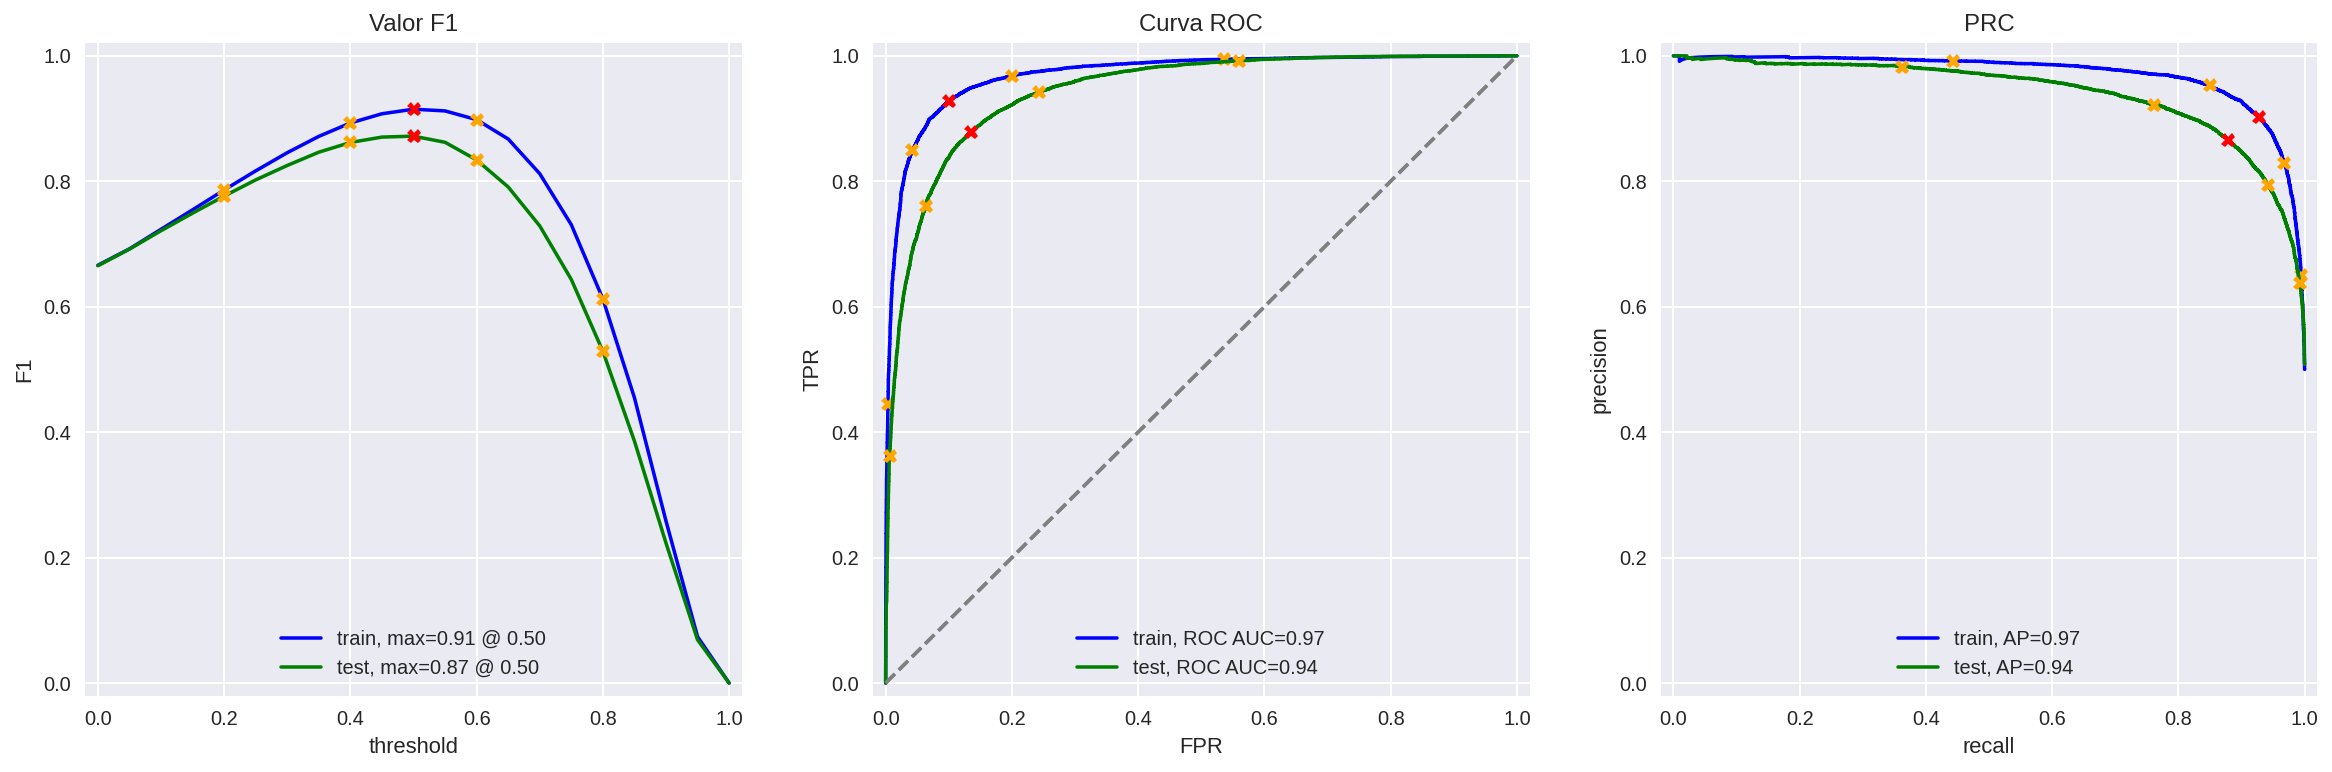

In [31]:
evaluate_model(model_3, f_train3, train_target, f_test3, test_target)

La puntuación F1 obtenida en el conjunto de pruebas es de 0,87, ligeramente inferior a la anterior, pero aún cumple con nuestro requisito mínimo establecido.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier <a id='Modelo_4_spaCy_TF_IDF_LGBMClassifier'></a>

Dado que continuamos utilizando spaCy y TF-IDF, podemos aprovechar los valores vectorizados obtenidos del último modelo. Nuestro enfoque será encontrar los parámetros óptimos para entrenar el modelo clasificador LightGBM.

In [32]:
#Obtener los mejores parámetros para el modelo clasificador LightGBM
model=LGBMClassifier()
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[10, 20],
            'objective':['binary'],
            'random_state':[12345]}
grid=GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train3, train_target)
best_param=grid.best_params_

In [33]:
print('Best score from searched params:', grid.best_score_)
print('Best parameters:', best_param)

Best score from searched params: 0.8343460423105388
Best parameters: {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'objective': 'binary', 'random_state': 12345}


In [34]:
#usando los mejores parametros de prueba y entrenamiento
model_4=LGBMClassifier(num_leaves=best_param['num_leaves'],
                      learning_rate=best_param['learning_rate'],
                      n_estimators=best_param['n_estimators'],
                      objective='binary',
                      random_state=12345)
model_4.fit(f_train3, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=20, num_leaves=30,
               objective='binary', random_state=12345)

modelo de evaluacion

          train  test
Accuracy   0.89  0.84
F1         0.90  0.84
APS        0.96  0.92
ROC AUC    0.96  0.92


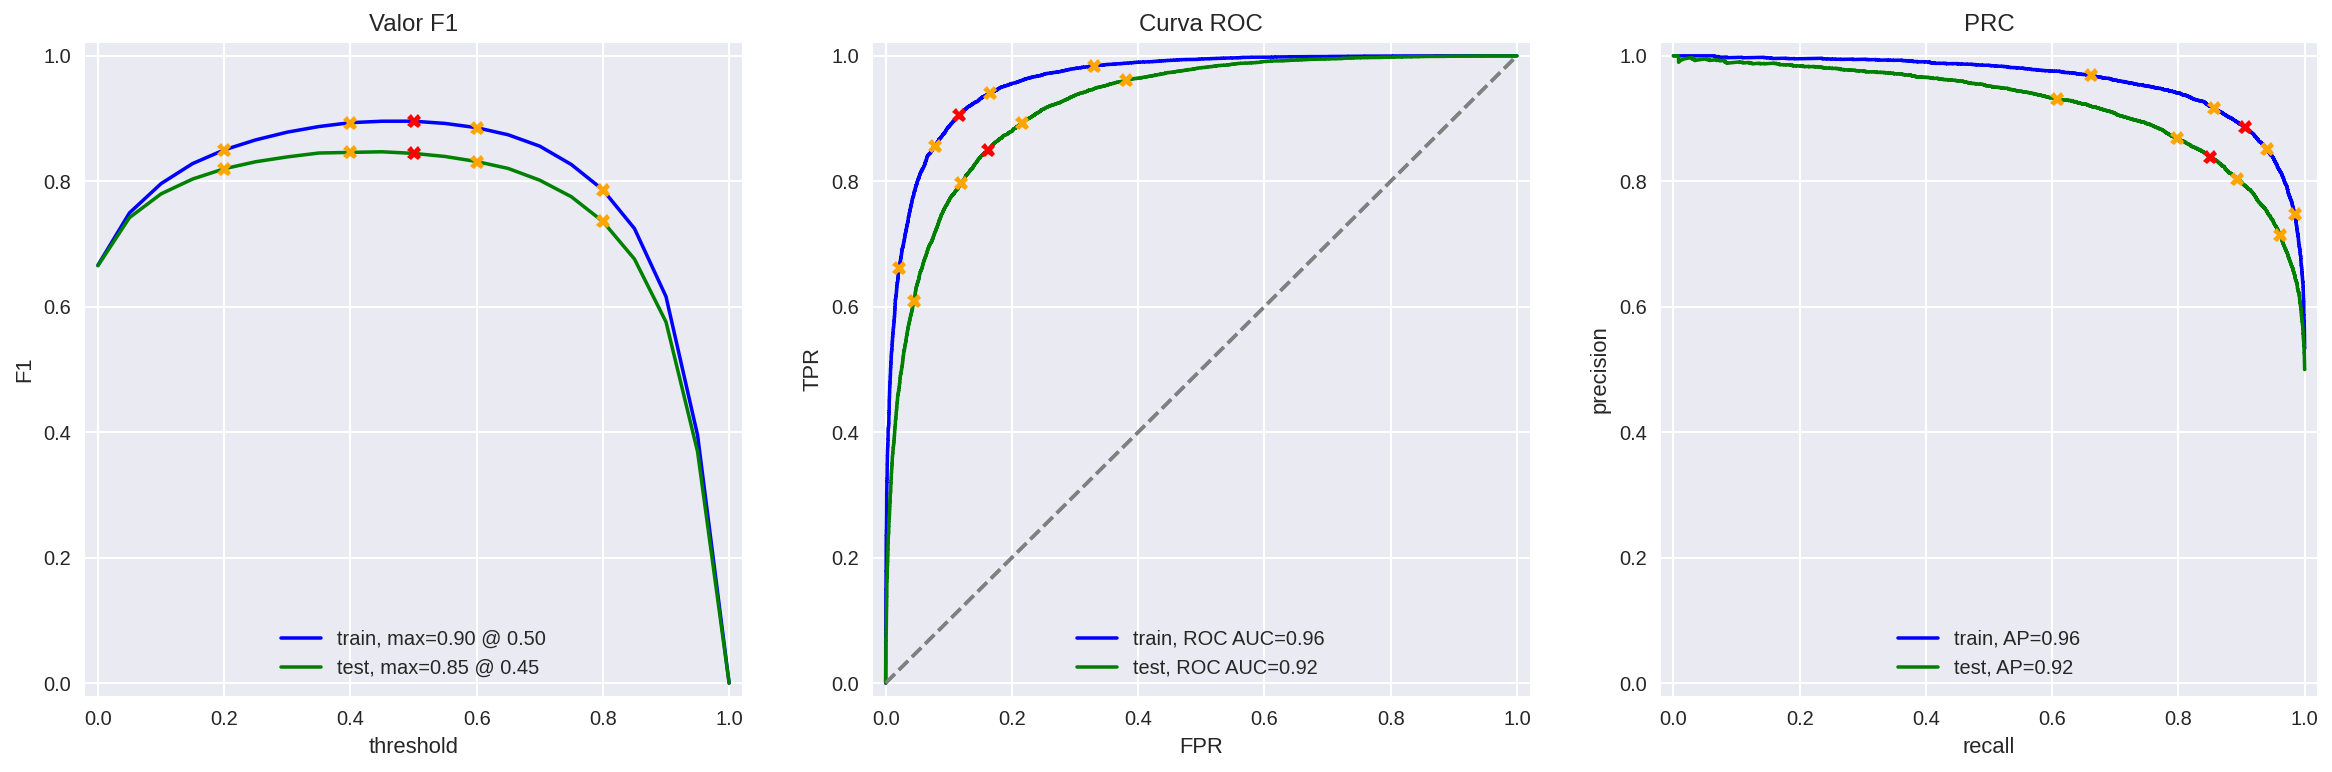

In [35]:
evaluate_model(model_4, f_train3, train_target, f_test3, test_target)

La puntuación F1 es de 0,84, un poco por debajo del mínimo exigido

## Mis reseñas <a id='My_reviews'></a>

In [36]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


Las primeras, segundas, cuartas y séptimas críticas son negativas, mientras que las terceras, quintas, sextas y octavas críticas son positivas.

### Modelo 2 <a id='Model_2'></a>

In [37]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.28:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.20:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.42:  i didn t expect the reboot to be so good writers really cared about the source material
0.46:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Asigna probabilidades más bajas de positividad a las quinta y sexta revisiones, las cuales son positivas.

### Modelo 3 <a id='Model_3'></a>

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.38:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.86:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Este modelo mostró una mayor tendencia a predecir valoraciones negativas en lugar de positivas, ya que acertó en todas las predicciones de valoraciones negativas y tuvo errores en las predicciones de valoraciones positivas, excepto en la última predicción.

### Modelo 4 <a id='Model_4'></a>

In [39]:
texts = my_reviews['review_norm']


my_reviews_pred_prob = model_4.predict_proba(count_tf_idf3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.28:  well i was bored and felt asleep in the middle of the movie
0.62:  i was really fascinated with the movie
0.38:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.62:  i didn t expect the reboot to be so good writers really cared about the source material
0.61:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Este modelo tuvo un solo error en la primera predicción, pero no es tan extremo como los otros modelos. La probabilidad máxima en este caso es del 75%, en contraste con el 86% y el 84% de los otros modelos.

## Conclusiones <a id='end'></a>

En resumen, al analizar los datos, observamos un aumento general en el número de películas por año, con un pico en 2006 seguido de una disminución. También notamos que en general, había menos películas con más críticas y que el número de críticas negativas superaba a las positivas cada año. Desarrollamos modelos para predecir si una crítica sería positiva o negativa, y encontramos que el modelo de regresión logística con procesamiento NLTK y vectorizador TF-IDF obtuvo la mejor puntuación F1 (0.87). No pudimos entrenar un modelo BERT debido a limitaciones de capacidad de procesamiento.
superando al menos nuestro objetivo valor F1 de al menos 0.85.

Advertencia: La ejecución de BERT en miles de textos puede llevar mucho tiempo en la CPU, posiblemente varias horas. Por esta razón, No entrenamos un modelo BERT porque no teníamos suficiente capacidad de procesamiento. y aparte los requqerimientos de mi pc son muy basicos